In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, cross_validate


from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier 

from statistics import mean
# to reduce randomness then you put the seed
np.random.seed(42)

from ArtificialImmuneSystem import *
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import KFold

from tabulate import tabulate
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [47]:
#Read the dataset
dataset = 'Data\hcv_data_split.csv'
df = pd.read_csv(dataset)


In [48]:
#Print out the old class distribution before oversampling
print(f"Old Class Distribution: {Counter(df['category'])}")

Data shape: 
(615, 14)

Data size: 
8610

Data ndim: 
2

_____________________________________________

Old Class Distribution: Counter({0: 540, 1: 75})


In [49]:
features =df.copy()
features = features.drop(['category'],axis=1)



c:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


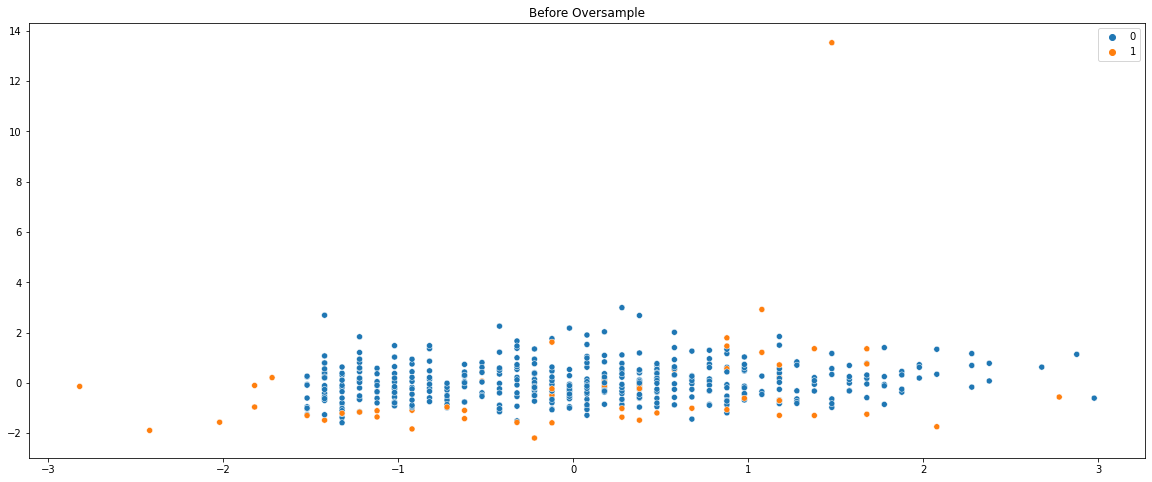

score1: 0.7733042499296369
score2: 0.6841589267285861
score1: 0.7733042499296369
score2: 0.7139498362273972
score1: 0.7733042499296369
score2: 0.6763157894736842
score1: 0.7733042499296369
score2: 0.6523880105401844
score1: 0.7733042499296369
score2: 0.6760315430520034
score1: 0.7733042499296369
score2: 0.7127873158832909
score1: 0.7733042499296369
score2: 0.7049068262540749
score1: 0.7733042499296369
score2: 0.7362878787878788
score1: 0.7733042499296369
score2: 0.7517825311942958
score1: 0.7733042499296369
score2: 0.7139498362273972
score1: 0.7733042499296369
score2: 0.7472370766488414
score1: 0.7733042499296369
score2: 0.657121212121212
score1: 0.7733042499296369
score2: 0.7185844173325664
score1: 0.7733042499296369
score2: 0.7092682542997135
score1: 0.7733042499296369
score2: 0.6962801388497983
score1: 0.7733042499296369
score2: 0.7173327704287455
score1: 0.7733042499296369
score2: 0.7218998332470818
score1: 0.7733042499296369
score2: 0.6711115030719934
score1: 0.7733042499296369
sc

c:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


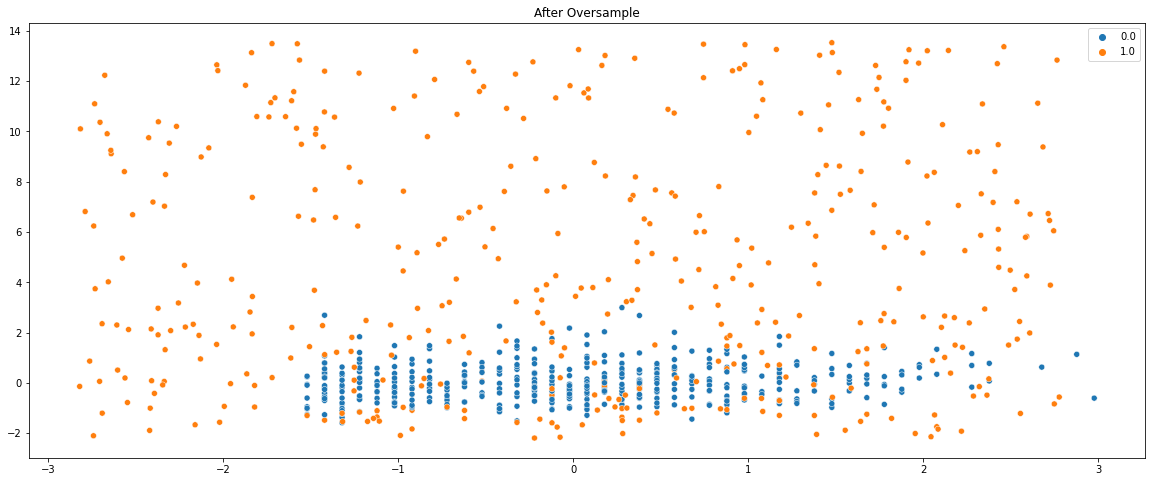

New Class Distribution: Counter({0.0: 433, 1.0: 433})
Best score GradientBoosting: 
0.9826495073054706

_____________________________________________

Best score GradientBoosting AIS: 
0.9444444444444444

Best score KNeighbors: 
0.9942235813795446

_____________________________________________

Best score KNeighbors AIS: 
0.9409828406388039

Best score Logistic Regression: 
0.9445506286102616

_____________________________________________

Best score Logistic Regression AIS: 
0.9294087665647299



KeyboardInterrupt: 

In [50]:
#K Fold Object set to 5 splits
kf = KFold(n_splits=5)

#Array to hold the data for AISOv between each fold
dataAIS = []
#Array to hold the data for SMOTE between each fold
dataSMOTE = []
#Array to hold the data for base between each fold
dataBase = []
#Array to hold all data
data = []
#Value to keep track of current fold
fold = 0
#Value to enter the current test param into the result csv
paramEntry = "max_rounds = 125, stopping_cond = 35, model = GradientBoostingClassifier(),K_folds = 5,scorer = 'f1',min_change = 0.01, use_lof = True, mutation_rate = 1.0"

#Go through each kfold 
for result in kf.split(df):
    #Increase fold count
    fold = fold+1

    #Get the train set
    data_train = df.iloc[result[0]]
    #Get the test data
    data_test =  df.iloc[result[1]]

    #Get the tain label
    label_train = data_train.copy()
    label_train = label_train.drop(['Age','Sex','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT','PROT','split'],axis=1) #Drop all except category for the train df
 
    #Get the test label
    label_test = data_test.copy()
    label_test = label_test.drop(['Age','Sex','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT','PROT','split'],axis=1) #Drop all except category for the train df
   
    #Drop the label from training set
    train_df = data_train.copy()
    train_df = train_df.drop(['category'],axis=1)

    #Get all numerical attributes
    numerical_attribute_train = train_df.drop(['split','Sex'],axis=1)
    
    #Create data preprossesing pipeline
    num_pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('std_scaler', StandardScaler()),
    ])

    num_attribs = list(numerical_attribute_train)
    cat_attribs = ["Sex"]

    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

    #Fit the pipeline to the train data
    data_prepared_train = pd.DataFrame(full_pipeline.fit_transform(train_df),columns=train_df.columns, index=train_df.index)
    rejoin_train = pd.concat([data_prepared_train,label_train],axis=1)

    #Create data preprossesing pipeline
    test_df = data_test.drop(['category'],axis=1) 
    num_pipeline_test = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('std_scaler', StandardScaler()),
    ])
    cat_attribs_test = ['split',"Sex"]
    numerical_attr_test = test_df.drop(['Sex'],axis=1)
    numerical_attr_test = list(numerical_attr_test)

    full_pipeline_test = ColumnTransformer([
        ("num", num_pipeline_test, numerical_attr_test),
        ("cat", OneHotEncoder(), cat_attribs_test),
    ])

    #Fit the pipeline to the train data
    data_prepared_test = pd.DataFrame(full_pipeline.fit_transform(test_df),columns=test_df.columns, index=test_df.index)
    rejoin_test = pd.concat([data_prepared_test,label_test],axis=1)
   
    
    data_train_AIS = rejoin_train.copy()
    data_train_SMOTE = rejoin_train.copy()

    #Drop split as we are using kfold
    data_train_AIS = data_train_AIS.drop(['split'],axis=1)
    data_train_SMOTE = data_train_SMOTE.drop(['split'],axis=1)

    data_train = rejoin_train.copy()
    data_test = rejoin_test.copy()

    #Plot the data before oversampling
    f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))
    sns.scatterplot(data_train_AIS.drop(["category"], axis=1).values[:,0],data_train_AIS.drop(["category"], axis=1).values[:,2], hue=data_train_AIS.drop(data_train_AIS.columns[0:-1],axis=1).values.ravel(),ax=ax1)
    ax1.set_title("Before Oversample")
    plt.show()


    data_train = data_train.drop(['split'],axis=1)
    data_test = data_test.drop(['split'],axis=1)
  
   
    #Create an SMOTE oversampling object
    oversample = SMOTE()

    #Intalize clasifers to enter into the parameter for AISOv
    randomForest = RandomForestClassifier()
    logisticRegression = LogisticRegression()
    kNeighbors = KNeighborsClassifier()
    gradientBoosting = GradientBoostingClassifier()

    #Create an AISOv oversampling object
    oversample_AIS = ArtificialImmuneSystem()

    #Oversample and add to the dataframe to fix the class imbalance
    logisticRegression = LogisticRegression()

    #Get the current computer time to time the oversampling object
    st = time.time()
    #Oversample using SMOTE
    x_over, y_over = oversample.fit_resample(data_train_SMOTE.drop(["category"], axis=1), data_train_SMOTE.drop(data_train_SMOTE.columns[0:-1],axis=1))
    #get the current time and record the overal time
    elapsed_time_SMOTE = time.time() - st

    #Get the current computer time to time the oversampling object
    st = time.time()
    #Oversample using SMOTE
    input_x_over_AIS, y_over_AIS = oversample_AIS.AIS_Resample(data_train_AIS.drop(["category"], axis=1), data_train_AIS.drop(data_train_AIS.columns[0:-1],axis=1), max_rounds = 100, stopping_cond = 30, model = logisticRegression,K_folds = 5,scorer = 'f1',min_change = 0.001, use_lof = False)
    #get the current time and record the overal time
    elapsed_time_AIS = time.time() - st

    #Rejoin the oversampled data for simplicity
    smote_df = pd.concat([x_over, y_over], axis=1)
    ais_df = pd.concat([input_x_over_AIS, y_over_AIS], axis=1)

    #Plot the oversampled data using AISOv
    f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))
    sns.scatterplot(ais_df.drop(["category"], axis=1).values[:,0],ais_df.drop(["category"], axis=1).values[:,2], hue=ais_df.drop(ais_df.columns[0:-1],axis=1).values.ravel(),ax=ax1)
    ax1.set_title("After Oversample")
    plt.show()

    #Print the new class distribution after oversampling
    print(f"New Class Distribution: {Counter(ais_df['category'])}")

    #Fit one vs rest Gradient Boosting classification
    gradientBoosting = GradientBoostingClassifier()
    gradientBoosting = gradientBoosting.fit(x_over, y_over.values.ravel())

    gradientBoosting_AIS = GradientBoostingClassifier()
    gradientBoosting_AIS = gradientBoosting.fit(input_x_over_AIS, y_over_AIS.values.ravel())

    gradientBoosting_Base = gradientBoosting.fit(data_train.drop(["category"], axis=1), data_train.drop(data_train.columns[0:-1],axis=1).values.ravel())

    #Fit random forest classifier to each model of oversample
    randomForest = RandomForestClassifier()
    randomForest = randomForest.fit(x_over,y_over.values.ravel())

    randomForest = RandomForestClassifier()
    randomForest_AIS  = randomForest.fit(input_x_over_AIS,y_over_AIS.values.ravel())

    randomForest_Base = randomForest.fit(data_train.drop(["category"], axis=1), data_train.drop(data_train.columns[0:-1],axis=1).values.ravel())

     #Fit knn classifier to each model of oversample
    kNeighbors = KNeighborsClassifier()
    kNeighbors = kNeighbors.fit(x_over,y_over.values.ravel())

    kNeighbors = KNeighborsClassifier()
    kNeighbors_AIS  = kNeighbors.fit(input_x_over_AIS,y_over_AIS.values.ravel())
    kNeighbors_Base = kNeighbors.fit(data_train.drop(["category"], axis=1), data_train.drop(data_train.columns[0:-1],axis=1).values.ravel())
    
    #Fit logistic regression classifier to each model of oversample
    logisticRegression = LogisticRegression(max_iter=5000)
    logisticRegression = logisticRegression.fit(x_over,y_over.values.ravel())

    logisticRegression = LogisticRegression(max_iter=5000)
    logisticRegression_AIS  = logisticRegression.fit(input_x_over_AIS,y_over_AIS.values.ravel())
    logisticRegression_Base = logisticRegression.fit(data_train.drop(["category"], axis=1), data_train.drop(data_train.columns[0:-1],axis=1).values.ravel())
    #logisticRegression_Base  = logisticRegression.fit(data_train.drop(["5"], axis=1), data_train.drop(data_train_AIS.columns[0:-1]).values.ravel())

    #Set the parameters of GradientBoosting for GridSearchCV
    parametersGradientBoosting = [
        {'learning_rate': [0.10,0.30,0.40],'min_samples_leaf': [4,8,15,20],'min_samples_split': [5,10,15,20], 'n_estimators': [10,30,40,50,60]}
    ]

    #Set the scoring parameters
    scoringX = {"roc_auc": "roc_auc", "bal_accuracy": "balanced_accuracy","accuracy": "accuracy","F1_macro": "f1_macro"}

    #Preform Gridsearch to find best parameters
    grid_searchGradientBoosting = GridSearchCV(gradientBoosting, parametersGradientBoosting, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    grid_searchGradientBoosting_AIS = GridSearchCV(gradientBoosting_AIS, parametersGradientBoosting, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    
    #Fit the GradientBoosting 
    grid_searchGradientBoosting.fit(x_over, y_over.values.ravel())
    grid_searchGradientBoosting_AIS.fit(input_x_over_AIS,y_over_AIS.values.ravel())
  
    #Print GridSearchCV Results
    
    #print(f"Best score GradientBoosting: \n{grid_searchGradientBoosting.best_score_}\n")
    #print("_____________________________________________\n")
    
    #print(f"Best score GradientBoosting AIS: \n{grid_searchGradientBoosting_AIS.best_score_}\n")

    #Set the parameters of KNeighbors for GridSearchCV
    parametersKNeighbors = [
        {'n_neighbors': [1,5,10,15],'weights':['uniform', 'distance'],'algorithm':['auto'], 'p': [1,5,10]}
    ]

    #Preform KNeighbors to find best parameters
    grid_searchKNeighbors = GridSearchCV(kNeighbors, parametersKNeighbors, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    grid_searchKNeighbors_AIS = GridSearchCV(kNeighbors_AIS, parametersKNeighbors, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

    #Fit the KNeighbors 
    grid_searchKNeighbors.fit(x_over, y_over.values.ravel())
    grid_searchKNeighbors_AIS.fit(input_x_over_AIS,y_over_AIS.values.ravel())

    #Print GridSearchCV Results
   
    #print(f"Best score KNeighbors: \n{grid_searchKNeighbors.best_score_}\n")
    #print("_____________________________________________\n")
   
    #print(f"Best score KNeighbors AIS: \n{grid_searchKNeighbors_AIS.best_score_}\n")
    
    #Set the parameters of LogisticRegression for GridSearchCV
    parametersLogisticRegression = [
        {'multi_class': ['ovr'],'penalty':['none','l2'], 'C': [1,5,10]}
    ]

    #Preform LogisticRegression to find best parameters
    grid_searchLogisticRegression = GridSearchCV(logisticRegression, parametersLogisticRegression, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    grid_searchLogisticRegression_AIS = GridSearchCV(logisticRegression_AIS, parametersLogisticRegression, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

    #Fit the LogisticRegression 
    grid_searchLogisticRegression.fit(x_over, y_over.values.ravel())
    grid_searchLogisticRegression_AIS.fit(input_x_over_AIS,y_over_AIS.values.ravel())

    #Print LogisticRegression Results
    
    #print(f"Best score Logistic Regression: \n{grid_searchLogisticRegression.best_score_}\n")
    #print("_____________________________________________\n")
   
    #print(f"Best score Logistic Regression AIS: \n{grid_searchLogisticRegression_AIS.best_score_}\n")

    #Set the parameters of RandomForest for GridSearchCV
    parametersRandomForest = [
        {'n_estimators': [50,100,150,200],'max_depth': [5,10,15,20], 'bootstrap': [True, False],
        'min_samples_split': [0.05,2,5,10], 'max_features': ['sqrt']}
    ]

    #Preform Gridsearch to find best parameters
    grid_searchRandomForest = GridSearchCV(randomForest, parametersRandomForest, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    grid_searchRandomForest_AIS = GridSearchCV(randomForest_AIS, parametersRandomForest, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

    #Fit the RandomForest 
    grid_searchRandomForest.fit(x_over, y_over.values.ravel())
    grid_searchRandomForest_AIS.fit(input_x_over_AIS,y_over_AIS.values.ravel())

    #Print GridSearchCV Results

    #print(f"Best score RandomForest: \n{grid_searchRandomForest.best_score_}\n")

    #print(f"Best score RandomForest AIS: \n{grid_searchRandomForest_AIS.best_score_}\n")

    #Get the results for all classifiers 
    cross_val_resultsGB = grid_searchGradientBoosting.cv_results_
    cross_val_resultsRF = grid_searchRandomForest.cv_results_
    cross_val_resultsLR = grid_searchLogisticRegression.cv_results_
    cross_val_resultsKN = grid_searchKNeighbors.cv_results_

    cross_val_resultsGB_AIS = grid_searchGradientBoosting_AIS.cv_results_
    cross_val_resultsRF_AIS = grid_searchRandomForest_AIS.cv_results_
    cross_val_resultsLR_AIS = grid_searchLogisticRegression_AIS.cv_results_
    cross_val_resultsKN_AIS = grid_searchKNeighbors_AIS.cv_results_


    #Print the results of all classiifiers
    #GBC
    mean_test_roc_aucGB = mean(cross_val_resultsGB['mean_test_roc_auc'])
    mean_test_bal_accuracyGB = mean(cross_val_resultsGB['mean_test_bal_accuracy'])
    
    mean_test_roc_aucGB_AIS = mean(cross_val_resultsGB_AIS['mean_test_roc_auc'])
    mean_test_bal_accuracyGB_AIS = mean(cross_val_resultsGB_AIS['mean_test_bal_accuracy'])
   
    #RFC
    mean_test_roc_aucRF = mean(cross_val_resultsRF['mean_test_roc_auc'])
    mean_test_bal_accuracyRF = mean(cross_val_resultsRF['mean_test_bal_accuracy'])
    
    mean_test_roc_aucRF_AIS = mean(cross_val_resultsRF_AIS['mean_test_roc_auc'])
    mean_test_bal_accuracyRF_AIS = mean(cross_val_resultsRF_AIS['mean_test_bal_accuracy'])
    #LRC
    mean_test_roc_aucLR = mean(cross_val_resultsLR['mean_test_roc_auc'])
    mean_test_bal_accuracyLR = mean(cross_val_resultsLR['mean_test_bal_accuracy'])
    
    mean_test_roc_aucLR_AIS = mean(cross_val_resultsLR_AIS['mean_test_roc_auc'])
    mean_test_bal_accuracyLR_AIS = mean(cross_val_resultsLR_AIS['mean_test_bal_accuracy'])

    #KNC
    mean_test_roc_aucKN = mean(cross_val_resultsKN['mean_test_roc_auc'])
    mean_test_bal_accuracyKN = mean(cross_val_resultsKN['mean_test_bal_accuracy'])
    
    mean_test_roc_aucKN_AIS = mean(cross_val_resultsKN_AIS['mean_test_roc_auc'])
    mean_test_bal_accuracyKN_AIS = mean(cross_val_resultsKN_AIS['mean_test_bal_accuracy'])

    #Using the best estimatior from grid search to predict the class label of the test set for the model with oversampling by SMOTE
    predictions_test_over_GB = grid_searchGradientBoosting.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_RF = grid_searchRandomForest.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_LR = grid_searchLogisticRegression.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_KN = grid_searchKNeighbors.best_estimator_.predict(data_test.drop(["category"],axis=1))

    #Using the best estimatior from grid search to predict the class label of the test set for the model with oversampling by AISOv
    predictions_test_over_GB_AIS = grid_searchGradientBoosting_AIS.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_RF_AIS = grid_searchRandomForest_AIS.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_LR_AIS = grid_searchLogisticRegression_AIS.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_KN_AIS = grid_searchKNeighbors_AIS.best_estimator_.predict(data_test.drop(["category"],axis=1))

    #predict the class label of the test set for the model with no oversampling
    predictions_GB = gradientBoosting_Base.predict(data_test.drop(["category"],axis=1))
    predictions_RF = randomForest_Base.predict(data_test.drop(["category"],axis=1))
    predictions_LR = logisticRegression_Base.predict(data_test.drop(["category"],axis=1))
    predictions_KN = kNeighbors_Base.predict(data_test.drop(["category"],axis=1))

    #Get the F1 score For the model with oversmpling by SMOTE
    f1_score_GB = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB)
    f1_score_RF = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF)
    f1_score_LR = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR)
    f1_score_KN = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN)

    #Get the F1 score For the model with oversmpling by AISOv
    f1_score_GB_AIS = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB_AIS) 
    f1_score_RF_AIS = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF_AIS)
    f1_score_LR_AIS = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR_AIS)
    f1_score_KN_AIS = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN_AIS)

    #Get the F1 score For the model without oversmpling
    f1_score_GB_Base = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_GB)
    f1_score_RF_Base = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_RF)
    f1_score_LR_Base = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_LR)
    f1_score_KN_Base = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_KN)

    #Get the geometric mean score For the model with oversmpling by SMOTE
    geometric_mean_score_GB = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_RF = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_LR = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_KN = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN, labels=None, pos_label=1, average='binary',)

    #Get the geometric mean score For the model with oversmpling by AISOv
    geometric_mean_score_GB_AIS = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB_AIS, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_RF_AIS = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF_AIS, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_LR_AIS = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR_AIS, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_KN_AIS = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN_AIS, labels=None, pos_label=1, average='binary',)

    #Get the geometric mean score For the model without oversmpling
    geometric_mean_score_GB_Base = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_GB, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_RF_Base = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_RF, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_LR_Base = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_LR, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_KN_Base = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_KN, labels=None, pos_label=1, average='binary',)

    #Get the ROC AUC score For the model with oversmpling by AISOv
    roc_auc_GB_AIS = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB_AIS)
    roc_auc_RF_AIS = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF_AIS)
    roc_auc_LR_AIS = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR_AIS)
    roc_auc_KN_AIS = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN_AIS)
 
    #Get the ROC AUC score For the model without oversmpling
    roc_auc_GB_Base = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_GB)
    roc_auc_RF_Base = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_RF)
    roc_auc_LR_Base = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_LR)
    roc_auc_KN_Base = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_KN)

    #Get the ROC AUC score For the model with oversmpling by SMOTE
    roc_auc_GB = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB)
    roc_auc_RF = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF)
    roc_auc_LR = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR)
    roc_auc_KN = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN)
    
    #Get the balanced accuracy score For the model with oversmpling by AISOv
    balanced_acc_GB_AIS = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB_AIS)
    balanced_acc_RF_AIS = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF_AIS)
    balanced_acc_LR_AIS = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR_AIS)
    balanced_acc_KN_AIS = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN_AIS)
 
    #Get the balanced accuracy score For the model with oversmpling by SMOTE
    balanced_acc_GB = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB)
    balanced_acc_RF = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF)
    balanced_acc_LR = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR)
    balanced_acc_KN = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN)

    #Get the balanced accuracy score For the model without oversmpling
    balanced_acc_GB_Base = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_GB)
    balanced_acc_RF_Base = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_RF)
    balanced_acc_LR_Base = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_LR)
    balanced_acc_KN_Base = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_KN)

    #Add all results to the dataAIS array for the fold
    dataAIS.append( [fold,dataset,"AIS", elapsed_time_AIS,paramEntry, roc_auc_GB_AIS, roc_auc_RF_AIS, roc_auc_LR_AIS, roc_auc_KN_AIS, balanced_acc_GB_AIS, balanced_acc_RF_AIS,  balanced_acc_LR_AIS,  balanced_acc_KN_AIS, geometric_mean_score_GB_AIS, geometric_mean_score_RF_AIS, geometric_mean_score_LR_AIS, geometric_mean_score_KN_AIS,f1_score_GB_AIS,f1_score_RF_AIS,f1_score_LR_AIS,f1_score_KN_AIS ])
    #Add all results to the dataSMOTE array for the fold
    dataSMOTE.append([fold,dataset,"SMOTE", elapsed_time_SMOTE,"NA", roc_auc_GB,  roc_auc_RF, roc_auc_LR,roc_auc_KN, balanced_acc_GB, balanced_acc_RF,  balanced_acc_LR,  balanced_acc_KN, geometric_mean_score_GB, geometric_mean_score_RF, geometric_mean_score_LR, geometric_mean_score_KN,f1_score_GB,f1_score_RF,f1_score_LR,f1_score_KN])
    #Add all results to the dataBase array for the fold
    dataBase.append([fold,dataset,"BASE", "NA","NA", roc_auc_GB_Base, roc_auc_RF_Base, roc_auc_LR_Base, roc_auc_KN_Base, balanced_acc_GB_Base, balanced_acc_RF_Base,balanced_acc_LR_Base,  balanced_acc_KN_Base, geometric_mean_score_GB_Base, geometric_mean_score_RF_Base, geometric_mean_score_LR_Base, geometric_mean_score_KN_Base,f1_score_GB_Base,f1_score_RF_Base,f1_score_LR_Base,f1_score_KN_Base])
    #Append the data to the data array
    data.append(dataAIS[fold-1])
    data.append(dataSMOTE[fold-1])
    data.append(dataBase[fold-1])
    #Append a break for the csv
    data.append(["","","","","","","","","","","","","","","","","","","","",""])

#Value to collect AISOv runtime
average_AIS_Runtime = 0

#Value to collect ROC AUC results for AISOv model
average_roc_auc_GB_AIS = 0
average_roc_auc_RF_AIS = 0
average_roc_auc_LR_AIS = 0
average_roc_auc_KN_AIS = 0

#Value to collect balanced accuracy results for AISOv model
average_balanced_acc_GB_AIS = 0
average_balanced_acc_RF_AIS = 0
average_balanced_acc_LR_AIS = 0
average_balanced_acc_KN_AIS = 0

#Value to collect geometric mean results for AISOv model
average_geometric_mean_score_GB_AIS = 0
average_geometric_mean_score_RF_AIS = 0
average_geometric_mean_score_LR_AIS = 0
average_geometric_mean_score_KN_AIS = 0
    
#Value to collect gradient boosting results for AISOv model
average_f1_score_GB_AIS = 0
average_f1_score_RF_AIS = 0
average_f1_score_LR_AIS = 0
average_f1_score_KN_AIS = 0

#Value to collect SMOTE runtime
average_SMOTE_Runtime = 0

#Value to collect ROC AUC results for SMOTE model
average_roc_auc_GB = 0
average_roc_auc_RF = 0
average_roc_auc_LR = 0
average_roc_auc_KN = 0

#Value to collect balanced accuracy results for SMOTE model
average_balanced_acc_GB = 0
average_balanced_acc_RF = 0
average_balanced_acc_LR = 0
average_balanced_acc_KN = 0

#Value to collect geometric mean results for SMOTE model
average_geometric_mean_score_GB = 0
average_geometric_mean_score_RF = 0
average_geometric_mean_score_LR = 0
average_geometric_mean_score_KN = 0
    
#Value to collect f1 results for SMOTE model
average_f1_score_GB = 0
average_f1_score_RF = 0
average_f1_score_LR = 0
average_f1_score_KN = 0

#Value to collect ROC AUC results for Base model
average_roc_auc_GB_Base = 0
average_roc_auc_RF_Base = 0
average_roc_auc_LR_Base = 0
average_roc_auc_KN_Base = 0

#Value to collect balanced accuracy results for Base model
average_balanced_acc_GB_Base = 0
average_balanced_acc_RF_Base = 0
average_balanced_acc_LR_Base = 0
average_balanced_acc_KN_Base = 0

#Value to collect geometric mean results for Base model
average_geometric_mean_score_GB_Base = 0
average_geometric_mean_score_RF_Base = 0
average_geometric_mean_score_LR_Base = 0
average_geometric_mean_score_KN_Base = 0
    
#Value to collect f1 results for Base model
average_f1_score_GB_Base = 0
average_f1_score_RF_Base = 0
average_f1_score_LR_Base = 0
average_f1_score_KN_Base = 0

#Calculate the average in each scorer for the AISOv model
for array in dataAIS:

    average_AIS_Runtime = average_AIS_Runtime + array[3]

    average_roc_auc_GB_AIS = average_roc_auc_GB_AIS + array[5]
    average_roc_auc_RF_AIS = average_roc_auc_RF_AIS + array[6]
    average_roc_auc_LR_AIS = average_roc_auc_LR_AIS + array[7]
    average_roc_auc_KN_AIS = average_roc_auc_KN_AIS + array[8]

    average_balanced_acc_GB_AIS = average_balanced_acc_GB_AIS + array[9]
    average_balanced_acc_RF_AIS = average_balanced_acc_RF_AIS + array[10]
    average_balanced_acc_LR_AIS = average_balanced_acc_LR_AIS + array[11]
    average_balanced_acc_KN_AIS = average_balanced_acc_KN_AIS + array[12]

    average_geometric_mean_score_GB_AIS = average_geometric_mean_score_GB_AIS + array[13]
    average_geometric_mean_score_RF_AIS = average_geometric_mean_score_RF_AIS + array[14]
    average_geometric_mean_score_LR_AIS = average_geometric_mean_score_LR_AIS + array[15]
    average_geometric_mean_score_KN_AIS = average_geometric_mean_score_KN_AIS + array[16]
    
    average_f1_score_GB_AIS = average_f1_score_GB_AIS + array[17]
    average_f1_score_RF_AIS = average_f1_score_RF_AIS + array[18]
    average_f1_score_LR_AIS = average_f1_score_LR_AIS + array[19]
    average_f1_score_KN_AIS = average_f1_score_KN_AIS + array[20]

#Calculate the average in each scorer for the SMOTE model
for array in dataSMOTE:

    average_SMOTE_Runtime = average_SMOTE_Runtime + array[3]

    average_roc_auc_GB = average_roc_auc_GB + array[5]
    average_roc_auc_RF = average_roc_auc_RF + array[6]
    average_roc_auc_LR = average_roc_auc_LR + array[7]
    average_roc_auc_KN = average_roc_auc_KN + array[8]

    average_balanced_acc_GB = average_balanced_acc_GB + array[9]
    average_balanced_acc_RF = average_balanced_acc_RF + array[10]
    average_balanced_acc_LR = average_balanced_acc_LR + array[11]
    average_balanced_acc_KN = average_balanced_acc_KN + array[12]

    average_geometric_mean_score_GB = average_geometric_mean_score_GB + array[13]
    average_geometric_mean_score_RF = average_geometric_mean_score_RF + array[14]
    average_geometric_mean_score_LR = average_geometric_mean_score_LR + array[15]
    average_geometric_mean_score_KN = average_geometric_mean_score_KN + array[16]
    
    average_f1_score_GB = average_f1_score_GB + array[17]
    average_f1_score_RF = average_f1_score_RF + array[18]
    average_f1_score_LR = average_f1_score_LR + array[19]
    average_f1_score_KN = average_f1_score_KN + array[20]

#Calculate the average in each scorer for the Base model
for array in dataBase:

    average_roc_auc_GB_Base = average_roc_auc_GB_Base + array[5]
    average_roc_auc_RF_Base = average_roc_auc_RF_Base + array[6]
    average_roc_auc_LR_Base = average_roc_auc_LR_Base + array[7]
    average_roc_auc_KN_Base = average_roc_auc_KN_Base + array[8]

    average_balanced_acc_GB_Base = average_balanced_acc_GB_Base + array[9]
    average_balanced_acc_RF_Base = average_balanced_acc_RF_Base + array[10]
    average_balanced_acc_LR_Base = average_balanced_acc_LR_Base + array[11]
    average_balanced_acc_KN_Base = average_balanced_acc_KN_Base + array[12]

    average_geometric_mean_score_GB_Base = average_geometric_mean_score_GB_Base + array[13]
    average_geometric_mean_score_RF_Base = average_geometric_mean_score_RF_Base + array[14]
    average_geometric_mean_score_LR_Base = average_geometric_mean_score_LR_Base + array[15]
    average_geometric_mean_score_KN_Base = average_geometric_mean_score_KN_Base + array[16]
    
    average_f1_score_GB_Base = average_f1_score_GB_Base + array[17]
    average_f1_score_RF_Base = average_f1_score_RF_Base + array[18]
    average_f1_score_LR_Base = average_f1_score_LR_Base + array[19]
    average_f1_score_KN_Base = average_f1_score_KN_Base + array[20]

#Calaculate the final averages
average_f1_score_GB = average_f1_score_GB / fold
average_f1_score_RF = average_f1_score_RF / fold
average_f1_score_LR = average_f1_score_LR / fold
average_f1_score_KN= average_f1_score_KN / fold

average_f1_score_GB_AIS = average_f1_score_GB_AIS / fold
average_f1_score_RF_AIS = average_f1_score_RF_AIS / fold
average_f1_score_LR_AIS = average_f1_score_LR_AIS / fold
average_f1_score_KN_AIS = average_f1_score_KN_AIS / fold

average_f1_score_GB_Base = average_f1_score_GB_Base / fold
average_f1_score_RF_Base = average_f1_score_RF_Base / fold
average_f1_score_LR_Base = average_f1_score_LR_Base / fold
average_f1_score_KN_Base= average_f1_score_KN_Base / fold

average_geometric_mean_score_GB = average_geometric_mean_score_GB / fold
average_geometric_mean_score_RF= average_geometric_mean_score_RF / fold
average_geometric_mean_score_LR= average_geometric_mean_score_LR / fold
average_geometric_mean_score_KN = average_geometric_mean_score_KN / fold

average_geometric_mean_score_GB_AIS= average_geometric_mean_score_GB_AIS / fold
average_geometric_mean_score_RF_AIS= average_geometric_mean_score_RF_AIS / fold
average_geometric_mean_score_LR_AIS = average_geometric_mean_score_LR_AIS / fold
average_geometric_mean_score_KN_AIS = average_geometric_mean_score_KN_AIS / fold

average_geometric_mean_score_GB_Base = average_geometric_mean_score_GB_Base / fold
average_geometric_mean_score_RF_Base= average_geometric_mean_score_RF_Base / fold
average_geometric_mean_score_LR_Base= average_geometric_mean_score_LR_Base / fold
average_geometric_mean_score_KN_Base= average_geometric_mean_score_KN_Base / fold

    
average_roc_auc_GB_AIS= average_roc_auc_GB_AIS / fold
average_roc_auc_RF_AIS= average_roc_auc_RF_AIS / fold
average_roc_auc_LR_AIS= average_roc_auc_LR_AIS / fold
average_roc_auc_KN_AIS= average_roc_auc_KN_AIS / fold
 
average_roc_auc_GB_Base = average_roc_auc_GB_Base / fold
average_roc_auc_RF_Base= average_roc_auc_RF_Base / fold
average_roc_auc_LR_Base= average_roc_auc_LR_Base / fold
average_roc_auc_KN_Base= average_roc_auc_KN_Base / fold

average_roc_auc_GB= average_roc_auc_GB / fold
average_roc_auc_RF= average_roc_auc_RF / fold
average_roc_auc_LR= average_roc_auc_LR / fold
average_roc_auc_KN= average_roc_auc_KN / fold

    

average_balanced_acc_GB_AIS= average_balanced_acc_GB_AIS / fold
average_balanced_acc_RF_AIS= average_balanced_acc_RF_AIS / fold
average_balanced_acc_LR_AIS= average_balanced_acc_LR_AIS / fold
average_balanced_acc_KN_AIS= average_balanced_acc_KN_AIS / fold
 
average_balanced_acc_GB= average_balanced_acc_GB / fold
average_balanced_acc_RF= average_balanced_acc_RF / fold
average_balanced_acc_LR= average_balanced_acc_LR / fold
average_balanced_acc_KN= average_balanced_acc_KN / fold

    
average_balanced_acc_GB_Base= average_balanced_acc_GB_Base / fold
average_balanced_acc_RF_Base= average_balanced_acc_RF_Base / fold
average_balanced_acc_LR_Base= average_balanced_acc_LR_Base / fold
average_balanced_acc_KN_Base= average_balanced_acc_KN_Base / fold


#Append the data to the csv data
data.append( ["","","AIS", "","AVERAGE:", average_roc_auc_GB_AIS, average_roc_auc_RF_AIS, average_roc_auc_LR_AIS, average_roc_auc_KN_AIS, average_balanced_acc_GB_AIS, average_balanced_acc_RF_AIS,  average_balanced_acc_LR_AIS,  average_balanced_acc_KN_AIS, average_geometric_mean_score_GB_AIS, average_geometric_mean_score_RF_AIS, average_geometric_mean_score_LR_AIS, average_geometric_mean_score_KN_AIS,average_f1_score_GB_AIS,average_f1_score_RF_AIS,average_f1_score_LR_AIS,average_f1_score_KN_AIS ])
data.append(["","","SMOTE", "","AVERAGE:", average_roc_auc_GB,  average_roc_auc_RF, average_roc_auc_LR,average_roc_auc_KN, average_balanced_acc_GB, average_balanced_acc_RF,  average_balanced_acc_LR,  average_balanced_acc_KN, average_geometric_mean_score_GB, average_geometric_mean_score_RF, average_geometric_mean_score_LR, average_geometric_mean_score_KN,average_f1_score_GB,average_f1_score_RF,average_f1_score_LR,average_f1_score_KN])
data.append(["","","BASE", "","AVERAGE:", average_roc_auc_GB_Base, average_roc_auc_RF_Base, average_roc_auc_LR_Base, average_roc_auc_KN_Base, average_balanced_acc_GB_Base, average_balanced_acc_RF_Base,balanced_acc_LR_Base,  average_balanced_acc_KN_Base, average_geometric_mean_score_GB_Base, average_geometric_mean_score_RF_Base, average_geometric_mean_score_LR_Base, average_geometric_mean_score_KN_Base,average_f1_score_GB_Base,average_f1_score_RF_Base,average_f1_score_LR_Base,average_f1_score_KN_Base])
data.append(["","","","","","","","","","","","","","","","","","","","",""])

In [ ]:
#Create a new CSV or append an existing one
col_names = ["Fold", "Dataset","Oversample","Oversample Run Time", "Oversample Paramaters", "ROC AUC for Gradient Boosting",  "ROC AUC for Random Forests", "ROC AUC for Logistic Regression",  "ROC AUC for K Nearest Neighbours", "Balanced Accuracy for Gradient Boosting", "Balanced Accuracy for Random Forests" ,"Balanced Accuracy for Logistic Regression","Balanced Accuracy for K Nearest Neighbours", "Geometric Mean Score for Gradient Boosting", "Geometric Mean Score for Random Forest", "Geometric Mean Score for Logestic Regression", "Geometric Mean Score for K Neighbors", "F1 Score for Gradient Boosting", "F1 Score for Random Forest", "F1 Score for Logestic Regression", "F1 Score for K Neighbors"]
dfoutput=pd.DataFrame(data,columns=col_names)
#Change name for new csv
title = "ExperimentalResults/ExperimentalComparisons-RealDataLOFComparisons.csv"
dfoutput.to_csv(title, mode='a',index=False) 

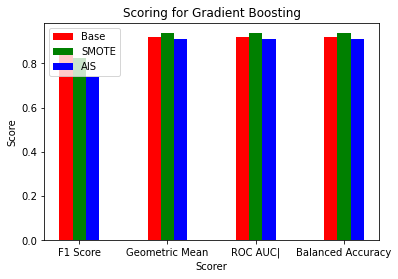

In [ ]:
n = 4
ind = np.arange(n)
width = 0.15

xvals = [average_f1_score_GB_Base, average_geometric_mean_score_GB_Base, average_roc_auc_GB_Base, average_balanced_acc_GB_Base]
bar1 = plt.bar(ind, xvals, width, color = 'r')

yvals = [average_f1_score_GB, average_geometric_mean_score_GB, average_roc_auc_GB, average_balanced_acc_GB]
bar2 = plt.bar(ind+width, yvals, width, color = 'g')

zvals = [average_f1_score_GB_AIS, average_geometric_mean_score_GB_AIS, average_roc_auc_GB_AIS, average_balanced_acc_GB_AIS]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')

plt.xlabel("Scorer")
plt.ylabel("Score")
plt.title("Scoring for Gradient Boosting")

plt.xticks(ind+width,["F1 Score", "Geometric Mean", "ROC AUC|", "Balanced Accuracy"])
plt.legend((bar1,bar2,bar3), ('Base','SMOTE', 'AIS'))

plt.show()

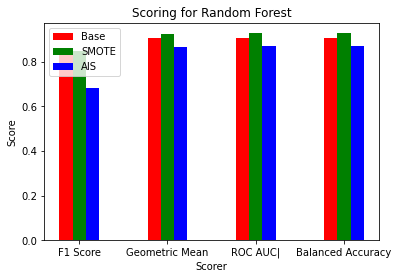

In [ ]:
n = 4
ind = np.arange(n)
width = 0.15

xvals = [average_f1_score_RF_Base, average_geometric_mean_score_RF_Base, average_roc_auc_RF_Base, average_balanced_acc_RF_Base]
bar1 = plt.bar(ind, xvals, width, color = 'r')

yvals = [average_f1_score_RF, average_geometric_mean_score_RF, average_roc_auc_RF, average_balanced_acc_RF]
bar2 = plt.bar(ind+width, yvals, width, color = 'g')

zvals = [average_f1_score_RF_AIS, average_geometric_mean_score_RF_AIS, average_roc_auc_RF_AIS, average_balanced_acc_RF_AIS]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')

plt.xlabel("Scorer")
plt.ylabel("Score")
plt.title("Scoring for Random Forest")

plt.xticks(ind+width,["F1 Score", "Geometric Mean", "ROC AUC|", "Balanced Accuracy"])
plt.legend((bar1,bar2,bar3), ('Base','SMOTE', 'AIS'))

plt.show()

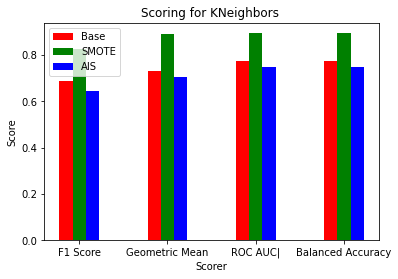

In [ ]:
n = 4
ind = np.arange(n)
width = 0.15

xvals = [average_f1_score_KN_Base, average_geometric_mean_score_KN_Base, average_roc_auc_KN_Base, average_balanced_acc_KN_Base]
bar1 = plt.bar(ind, xvals, width, color = 'r')

yvals = [average_f1_score_KN, average_geometric_mean_score_KN, average_roc_auc_KN, average_balanced_acc_KN]
bar2 = plt.bar(ind+width, yvals, width, color = 'g')

zvals = [average_f1_score_KN_AIS, average_geometric_mean_score_KN_AIS, average_roc_auc_KN_AIS, average_balanced_acc_KN_AIS]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')

plt.xlabel("Scorer")
plt.ylabel("Score")
plt.title("Scoring for KNeighbors ")

plt.xticks(ind+width,["F1 Score", "Geometric Mean", "ROC AUC|", "Balanced Accuracy"])
plt.legend((bar1,bar2,bar3), ('Base','SMOTE', 'AIS'))

plt.show()

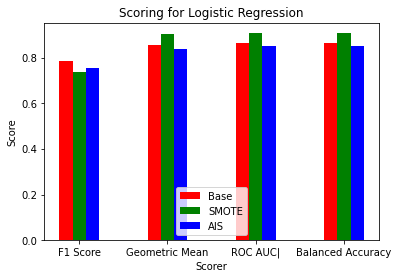

In [ ]:
n = 4
ind = np.arange(n)
width = 0.15

xvals = [average_f1_score_LR_Base, average_geometric_mean_score_LR_Base, average_roc_auc_LR_Base, average_balanced_acc_LR_Base]
bar1 = plt.bar(ind, xvals, width, color = 'r')

yvals = [average_f1_score_LR, average_geometric_mean_score_LR, average_roc_auc_LR, average_balanced_acc_LR]
bar2 = plt.bar(ind+width, yvals, width, color = 'g')

zvals = [average_f1_score_LR_AIS, average_geometric_mean_score_LR_AIS, average_roc_auc_LR_AIS, average_balanced_acc_LR_AIS]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')

plt.xlabel("Scorer")
plt.ylabel("Score")
plt.title("Scoring for Logistic Regression")

plt.xticks(ind+width,["F1 Score", "Geometric Mean", "ROC AUC|", "Balanced Accuracy"])
plt.legend((bar1,bar2,bar3), ('Base','SMOTE', 'AIS'))

plt.show()